In [18]:

from BenchmarkProblems.RoyalRoad import RoyalRoad
from Core.get_pRef import get_pRef_from_metaheuristic
from Core.PS import PS

problem = RoyalRoad(5)

pRef = get_pRef_from_metaheuristic(problem=problem,
                                   sample_size=10000,
                                   which_algorithm="GA",
                                   unique=True)
print(pRef)
to_explain = PS.from_string("1"*20)

PRef with 1043 samples, mean = 8.15


In [19]:


from Core.PS import PS
from Core.PSMetric.Linkage.TraditionalPerturbationLinkage import TraditionalPerturbationLinkage

pattern_1 = PS.from_string("1"*4 + "*" * 16)
pattern_2 = PS.from_string("1"*2 + "*"*2 +"1"*2 + "*"*2 + "*" * 12)




atomicity_metric = TraditionalPerturbationLinkage(problem)
atomicity_metric.set_solution(to_explain)


def atomicity(ps):
    return -atomicity_metric.get_atomicity(ps)


def dependence(ps):
    return atomicity_metric.get_dependence(ps)

print( atomicity(pattern_1), dependence(pattern_1))
print( atomicity(pattern_2), dependence(pattern_2))

-4.0 0.0
-0.0 4.0


In [3]:
from SimplifiedSystem.ps_search_utils import run_pymoo_algorithm_with_checks
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from SimplifiedSystem.Operators.Sampling import LocalPSGeometricSampling
from SimplifiedSystem.LocalPSSearchTask import LocalPSSearchTask

objectives = [atomicity, dependence]
population_size = 100

ga_problem = LocalPSSearchTask(solution_to_explain=to_explain,
                                objectives=objectives,
                                # unexplained_mask=None,
                                proportion_unexplained_that_needs_used=0.01,
                                proportion_used_that_should_be_unexplained=0.01)

# if there are no operators given, we have these defaults
sampling_operator = LocalPSGeometricSampling()
crossover_operator = SimulatedBinaryCrossover(prob=0.3)
mutation_operator = BitflipMutation(prob=1 / ga_problem.n_var)

# the next line of code is a bit odd, but it works! It uses a GA if there is one objective
algorithm = (GA if len(objectives) < 2 else NSGA2)(pop_size=population_size,
                                                   sampling=sampling_operator,
                                                   crossover=crossover_operator,
                                                   mutation=mutation_operator,
                                                   eliminate_duplicates=True)

pss = run_pymoo_algorithm_with_checks(pymoo_problem=ga_problem,
                                      algorithm=algorithm,
                                      reattempts_when_fail=5,
                                      ps_budget = 10000,
                                      verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       62 |     17 |  0.000000E+00 |  0.0080645161 |             - |             -
     2 |      162 |     19 |  0.000000E+00 |  0.000000E+00 |  0.1428571429 |         ideal
     3 |      262 |     22 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     4 |      362 |     22 |  0.000000E+00 |  0.000000E+00 |  0.2500000000 |         ideal
     5 |      462 |     24 |  0.000000E+00 |  0.000000E+00 |  0.1111111111 |         ideal
     6 |      562 |     24 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |      662 |      1 |  0.000000E+00 |  0.000000E+00 |  4.0000000000 |         nadir
     8 |      762 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |      862 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |      962 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

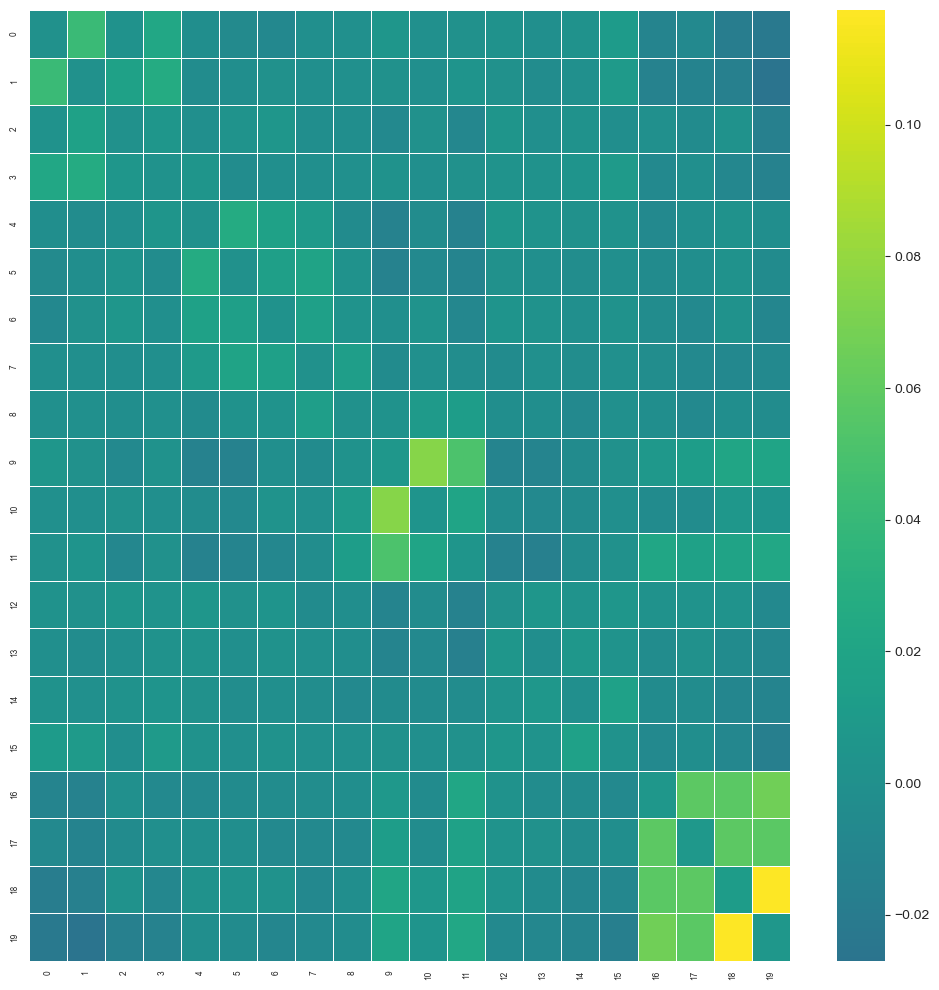

In [20]:
from utils import show_matrix_with_colours
from Core.PSMetric.Linkage.ValueSpecificMutualInformation import FasterSolutionSpecificMutualInformation

mi = FasterSolutionSpecificMutualInformation()
mi.set_pRef(pRef)
mi.set_solution(to_explain)

show_matrix_with_colours(mi.linkage_table)

In [21]:


from Core.FullSolution import FullSolution

univariate_counts = {(a, b) : len(pRef.fitnesses_of_observations(PS.empty(problem.search_space).with_fixed_value(a, b)))/pRef.sample_size
                     for a, cardinality in enumerate(problem.search_space.cardinalities)
                     for b in range(cardinality)}

bivariate_counts = {(a, b, c, d) : len(pRef.fitnesses_of_observations(PS.empty(problem.search_space).with_fixed_value(a, b).with_fixed_value(c, d)))/pRef.sample_size
                     for a, cardinality_a in enumerate(problem.search_space.cardinalities)
                     for b in range(cardinality_a)
                     for c, cardinality_c in enumerate(problem.search_space.cardinalities)
                     for d in range(cardinality_c)
                     }




def food(solution: FullSolution):
    return sum(univariate_counts[a, b] for a, b in enumerate(solution.values))


all_solutions = pRef.get_evaluated_FSs()
all_solutions.sort(key=food)

In [22]:
for s in all_solutions[:10]+all_solutions[-10:]:
    print(s)

(0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1), fs score = 0.00
(0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1), fs score = 0.00
(0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0), fs score = 0.00
(0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1), fs score = 0.00
(0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0), fs score = 0.00
(0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1), fs score = 0.00
(1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1), fs score = 0.00
(0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 1 1), fs score = 4.00
(0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1), fs score = 4.00
(0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1), fs score = 0.00
(1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1), fs score = 16.00
(1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1), fs score = 12.00
(1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1), fs score = 16.00
(1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1), fs score = 16.00
(1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0), fs score = 16.00
(1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1), fs score = 16.00
(1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1), fs scor

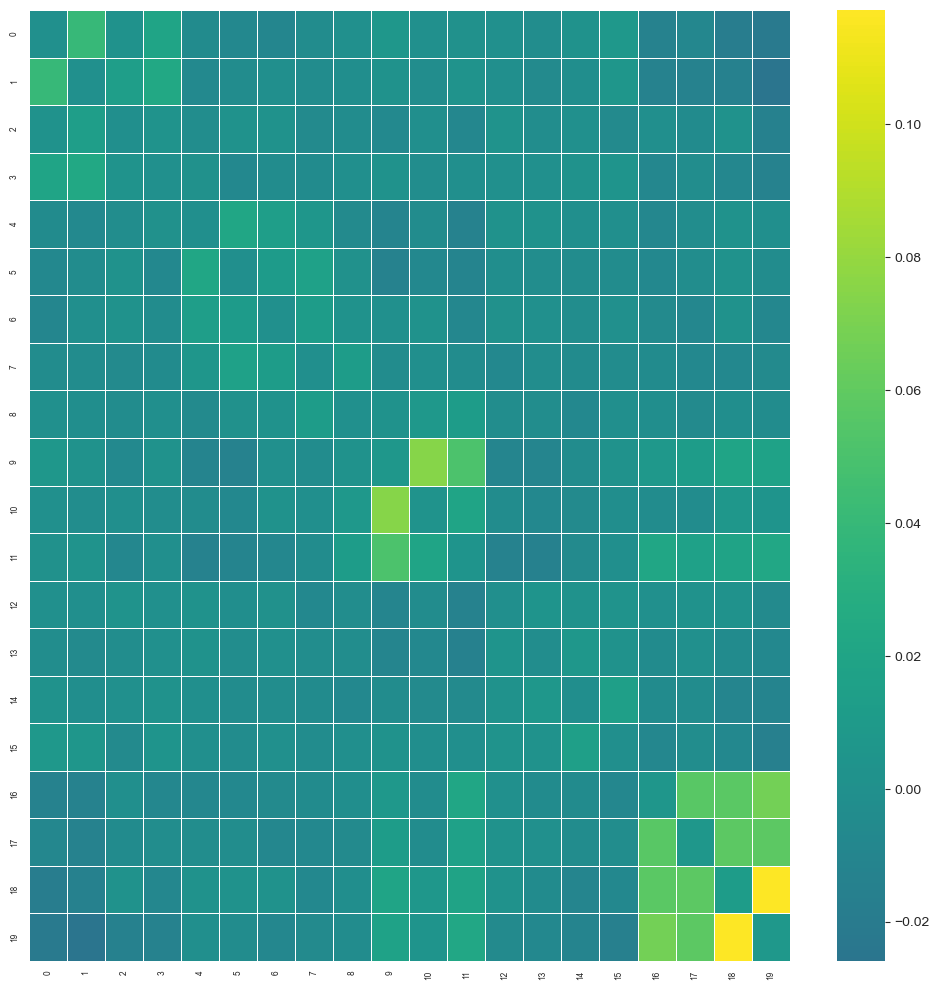

In [28]:
from Core.PRef import PRef
import heapq

cleaned_solutions = heapq.nlargest(iterable=all_solutions, key=food, n=1000)
cleaned_pRef = PRef.from_evaluated_full_solutions(cleaned_solutions, search_space=pRef.search_space)

mi = FasterSolutionSpecificMutualInformation()
mi.set_pRef(cleaned_pRef)
mi.set_solution(to_explain)

show_matrix_with_colours(mi.linkage_table)